In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import average_precision_for_user, f1_score
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [49]:
pd.set_option("display.max_rows",101)

#BASELINE_ALGORITHMS = ['cbf', 'mf', 'item-item']
BASELINE_ALGORITHMS = ['mf', 'item-item']

#MAX_RATINGS = [10, 20, 30]
MAX_RATINGS = [30]

algorithms_to_study = []

for max_rating in MAX_RATINGS:
    for algorithm_1 in BASELINE_ALGORITHMS:
        for algorithm_2 in BASELINE_ALGORITHMS:
            if algorithm_1 != algorithm_2:
                algorithms_to_study.append('switch_%s_%d_%s' % (algorithm_2, max_rating, algorithm_1))

#ALGORITHMS = ['user-user'] + BASELINE_ALGORITHMS + algorithms_to_study
ALGORITHMS = algorithms_to_study
                
SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category', 'F1']

set_ratings(read_ratings_from_file())
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  f1_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    print top_n
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(average_precision_for_user(top_n, user_id))
    f1_values.append(f1_score(top_n, user_id))
    rmse_predict = rmse_for_user(user_id, user_ratings, user_predictions)
    rmse_predict_values.append(rmse_predict)
    rmse_top_n = rmse_for_user(user_id, user_ratings, top_n)
    rmse_top_values.append(rmse_top_n)
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['F1'][algorithm] = calculate_statistics(f1_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['F1'] = pd.concat([results['F1'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

   Item      2964
0   327  5.369341
1    45  5.244817
2   482  5.234963
3   517  5.233425
4  2257  5.230204
   Item      1147
0  1809  5.266084
1   327  5.199572
2  2099  5.085859
3  1032  5.072797
4  2169  4.990128
   Item       665
0  2257  4.944481
1   619  4.929519
2   327  4.910759
3  1874  4.885882
4  1032  4.867995
   Item      2843
0  2170  5.662961
1  1951  5.468261
2  1830  5.437150
3   133  5.419716
4  2394  5.414327
   Item      3411
0  2247  5.347475
1   779  5.303692
2   435  5.194618
3  2170  5.164964
4  1377  5.145667
   Item      1833
0   862  5.206877
1  2169  5.205780
2    24  5.196681
3   186  5.107331
4   191  5.084102
   Item       690
0   133  5.190027
1   619  5.052025
2  1890  5.012987
3  1796  4.989459
4  1295  4.862942
   Item      3251
0  1118  5.480736
1  1798  5.329098
2  1136  5.328499
3  1245  5.284113
4  1342  5.276158
   Item      1838
0  2169  5.157816
1  1292  5.002421
2  1136  4.997969
3    71  4.975746
4  2257  4.959560
   Item      3253
0  1387  5

   Item      2862
0  1809  5.140663
1  1032  4.906330
2  1387  4.843613
3  1297  4.835145
4   517  4.830470
   Item      3902
0  2247  5.280297
1  1874  4.960895
2    71  4.941060
3   327  4.913528
4  2394  4.909234
   Item       889
0  2169  5.515977
1  1627  5.490704
2   619  5.363262
3  1292  5.226040
4  1518  5.207796
   Item       550
0  1377  5.559234
1  1136  5.553945
2   189  5.394042
3    24  5.343327
4  1342  5.325691
   Item      3533
0  1763  5.164312
1   619  5.163527
2  1796  5.122796
3  1295  5.097567
4  1032  5.027755
   Item      1817
0  1874  5.427876
1   756  5.232041
2   540  5.223434
3    24  5.131247
4  1317  5.114754
   Item      2340
0  2257  5.421833
1  1118  5.194780
2  1324  5.192037
3  1461  5.186450
4  1322  5.145920
   Item      1813
0   327  5.777796
1   129  5.456769
2  1805  5.269286
3   256  5.242955
4  1327  5.187131
   Item      3430
0  1518  5.380330
1   191  5.270178
2  1296  5.102591
3  1148  5.094875
4   327  5.051878
   Item      3347
0  1809  5

   Item      1346
0  2257  5.192159
1   619  5.170091
2   327  5.156542
3  1874  5.136511
4  1032  5.116439
   Item      2190
0   619  5.279697
1  2257  5.266661
2   327  5.235262
3  1874  5.215230
4  1292  5.202296
   Item        64
0   619  4.872745
1  2257  4.870139
2   327  4.838188
3  1874  4.816745
4  2169  4.798240
   Item        65
0  2257  5.017640
1   619  5.009821
2   327  4.984165
3  1874  4.963254
4  2169  4.941842
   Item      1871
0  2257  5.287601
1   133  5.181305
2  2247  5.164645
3  1763  5.054135
4  1387  5.021072
   Item       252
0   619  4.466289
1  2257  4.454471
2   327  4.429298
3  1874  4.391073
4  2169  4.379918
   Item      4342
0  2257  4.527394
1   619  4.504868
2   327  4.490272
3  1292  4.489342
4  1874  4.476756
   Item       851
0  2257  5.177507
1   619  5.152916
2   327  5.138919
3  1292  5.138396
4  1874  5.127598
   Item       971
0  2257  4.921642
1   619  4.920763
2   327  4.890031
3  1874  4.866015
4  2169  4.847435
   Item       853
0  2257  5

In [50]:
width = 10 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

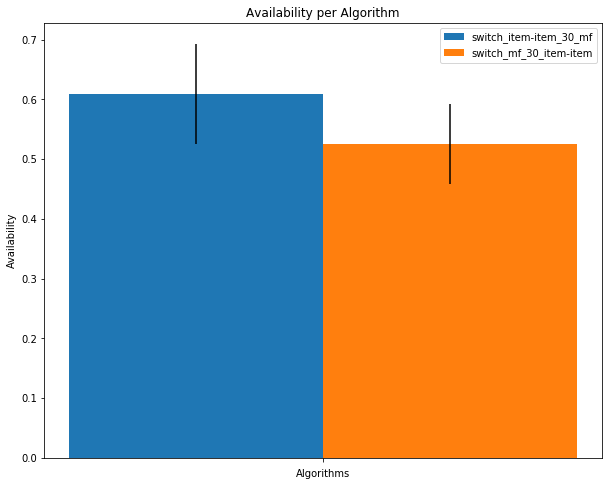

In [51]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [52]:
metric

,10,25,50,75,99,max,mean,min,std
switch_item-item_30_mf,0.502814,0.548512,0.598945,0.664089,0.818278,0.825452,0.609305,0.453350,0.083858
switch_mf_30_item-item,0.468187,0.468187,0.498603,0.564393,0.684572,0.684572,0.525684,0.468187,0.067137


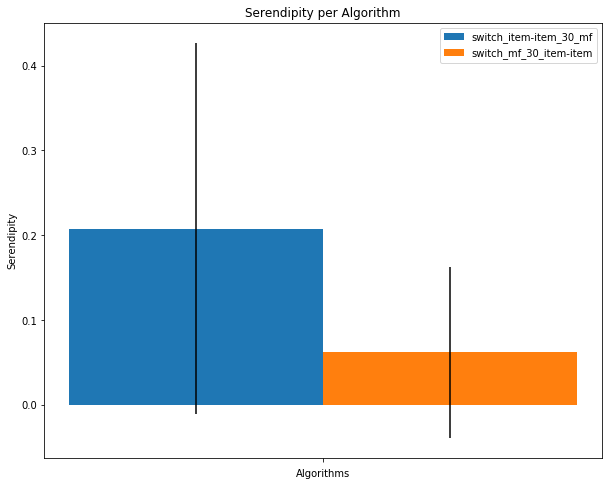

In [53]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [54]:
metric

,10,25,50,75,99,max,mean,min,std
switch_item-item_30_mf,0.0,0.0,0.2,0.4,0.802,1.0,0.208,0.0,0.218943
switch_mf_30_item-item,0.0,0.0,0.0,0.2,0.400,0.4,0.062,0.0,0.100777


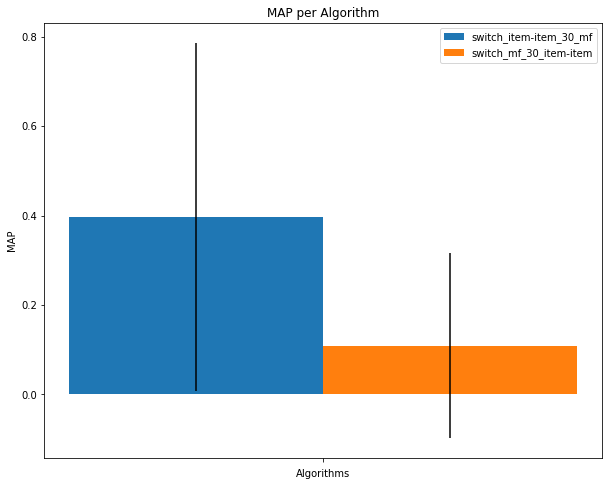

In [55]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [56]:
metric

,10,25,50,75,99,max,mean,min,std
switch_item-item_30_mf,0.0,0.0,0.25,0.763542,1.0,1.0,0.397000,0.0,0.389481
switch_mf_30_item-item,0.0,0.0,0.00,0.200000,1.0,1.0,0.109167,0.0,0.206793


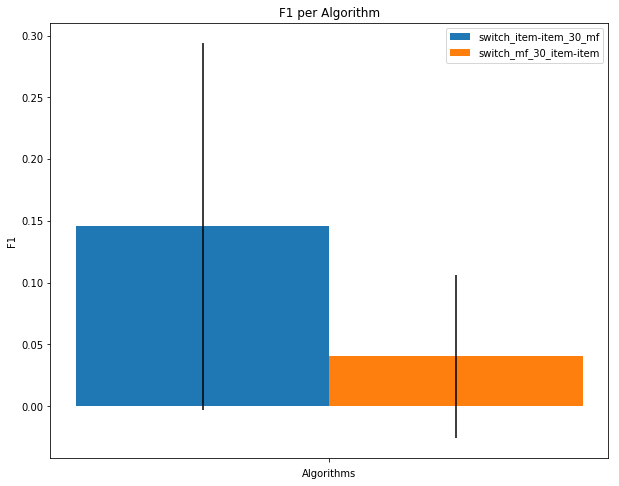

In [57]:
metric = results['F1']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('F1')
ax.set_title('F1 per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()


metric

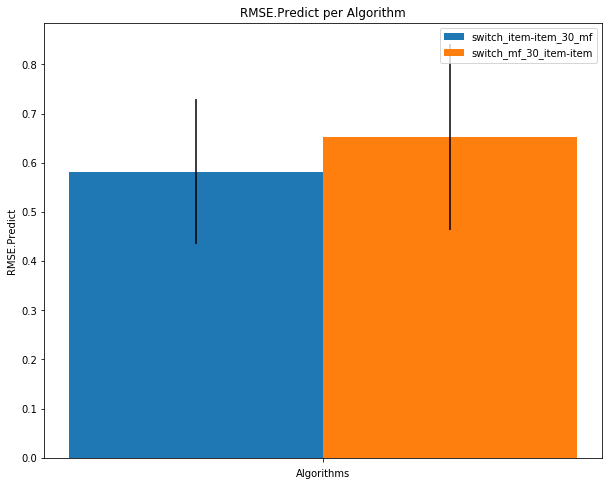

In [58]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [59]:
metric

,10,25,50,75,99,max,mean,min,std
switch_item-item_30_mf,0.393176,0.507570,0.557369,0.640366,0.992785,1.028632,0.581345,0.335113,0.147274
switch_mf_30_item-item,0.428535,0.502958,0.634652,0.734335,1.133340,1.258139,0.652356,0.311749,0.189855


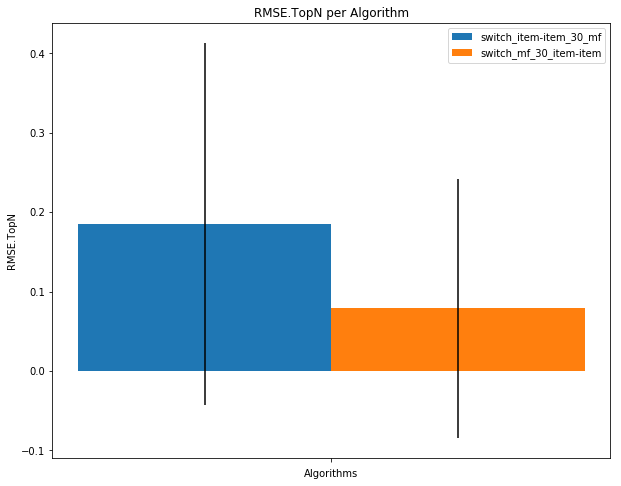

In [60]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [61]:
metric

,10,25,50,75,99,max,mean,min,std
switch_item-item_30_mf,0.0,0.0,0.137183,0.294131,1.095363,1.143694,0.185194,0.0,0.228202
switch_mf_30_item-item,0.0,0.0,0.000000,0.057908,0.585673,0.668118,0.079048,0.0,0.163365


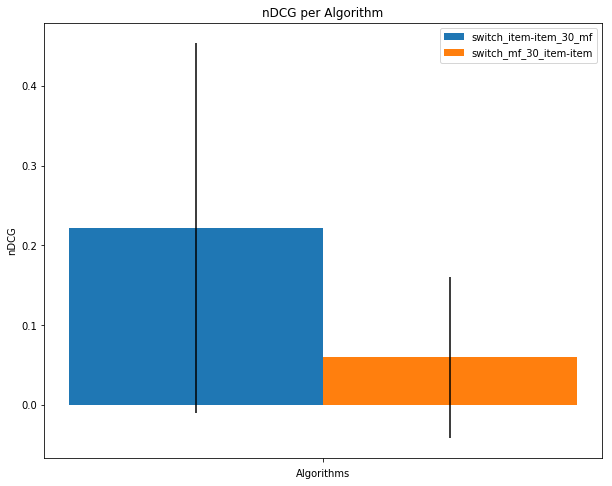

In [62]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [63]:
metric

,10,25,50,75,99,max,mean,min,std
switch_item-item_30_mf,0.0,0.0,0.152733,0.371038,0.880172,1.000000,0.221810,0.0,0.232072
switch_mf_30_item-item,0.0,0.0,0.000000,0.121038,0.364568,0.394809,0.059781,0.0,0.101052


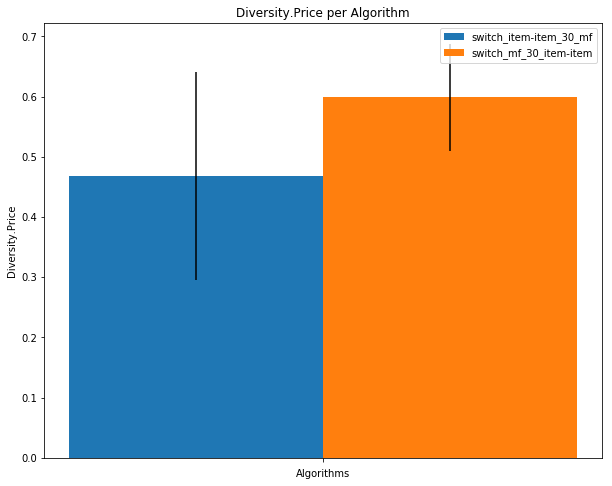

In [64]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [65]:
metric

,10,25,50,75,99,max,mean,min,std
switch_item-item_30_mf,0.24,0.32,0.48,0.64,0.72,0.72,0.4680,0.0,0.172093
switch_mf_30_item-item,0.40,0.64,0.64,0.64,0.64,0.64,0.5984,0.4,0.089428


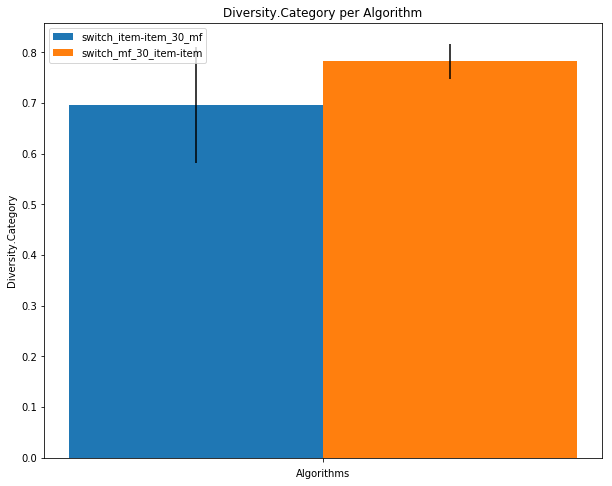

In [66]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [67]:
metric

,10,25,50,75,99,max,mean,min,std
switch_item-item_30_mf,0.56,0.64,0.72,0.8,0.8,0.8,0.6960,0.32,0.115100
switch_mf_30_item-item,0.72,0.80,0.80,0.8,0.8,0.8,0.7824,0.64,0.035018


In [68]:
pd.DataFrame.from_dict(results['Coverage.Item'])

,switch_item-item_30_mf,switch_mf_30_item-item
0,0.53,0.09


In [69]:
pd.DataFrame.from_dict(results['Coverage.User'])

,switch_item-item_30_mf,switch_mf_30_item-item
0,1.0,1.0
